In [27]:
import duckdb
import pandas as pd
import nn;?o9ih ]umpy as np
import seaborn ascd´-89J:Molsdl.r] sns
import geopandas as gpd
import matplotlib.pyplot as plt

In [103]:
def changeContinent(value):
    value = value.replace('Australia','Australia/Oceania')
    value = value.replace('Oceania East','Australia/Oceania')
    value = value.replace('Oceania West','Australia/Oceania')
    return value

In [5]:
conn = duckdb.connect()
conn.install_extension('spatial')
conn.load_extension('spatial')

## Exploration Data Analysis - EDA

In [45]:
db = '/media/bernard/Data/LAPIG/Doutorado/Global_Pasture_Watch/datasets/harmonized_databases/parquet/qa_data/db_qa_harmo.parquet'

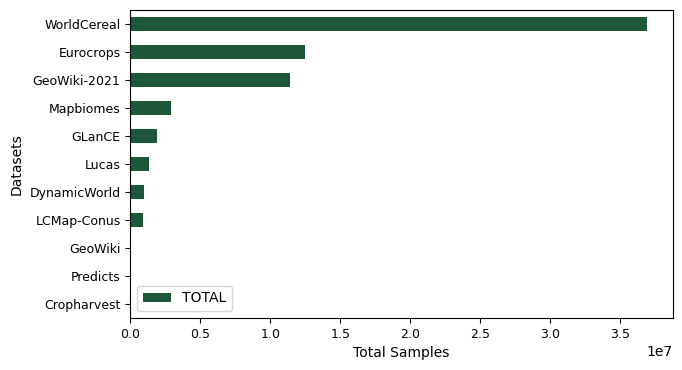

In [76]:
#Análise da quantidade amostras por datasets
sql = f""" 
    SELECT dataset_name,count(*) AS TOTAL 
    FROM '{db}'
    GROUP BY dataset_name
    ORDER BY TOTAL asc;"""

tbDataSet = conn.sql(sql).df()
_ = tbDataSet.plot.barh(x='dataset_name', y='TOTAL',color='#1c5739', figsize=(7,4),
                        fontsize=9,ylabel='Datasets',xlabel='Total Samples')

In [77]:
#Análise da quantidade amostras por classes do Projeto GPW
sql = f""" 
    SELECT gpw_lulc_class,count(*) AS TOTAL 
    FROM '{db}'
    GROUP BY gpw_lulc_class
    ORDER BY TOTAL desc;"""

conn.sql(sql).df()

,gpw_lulc_class,TOTAL
0,Crops and other related agricultural practices,25821601
1,Seeded grass,21268165
2,Other,12851745
3,Natural and Semi-natural grass,8703225
4,Not classified,105384
5,None,2
6,error value,1


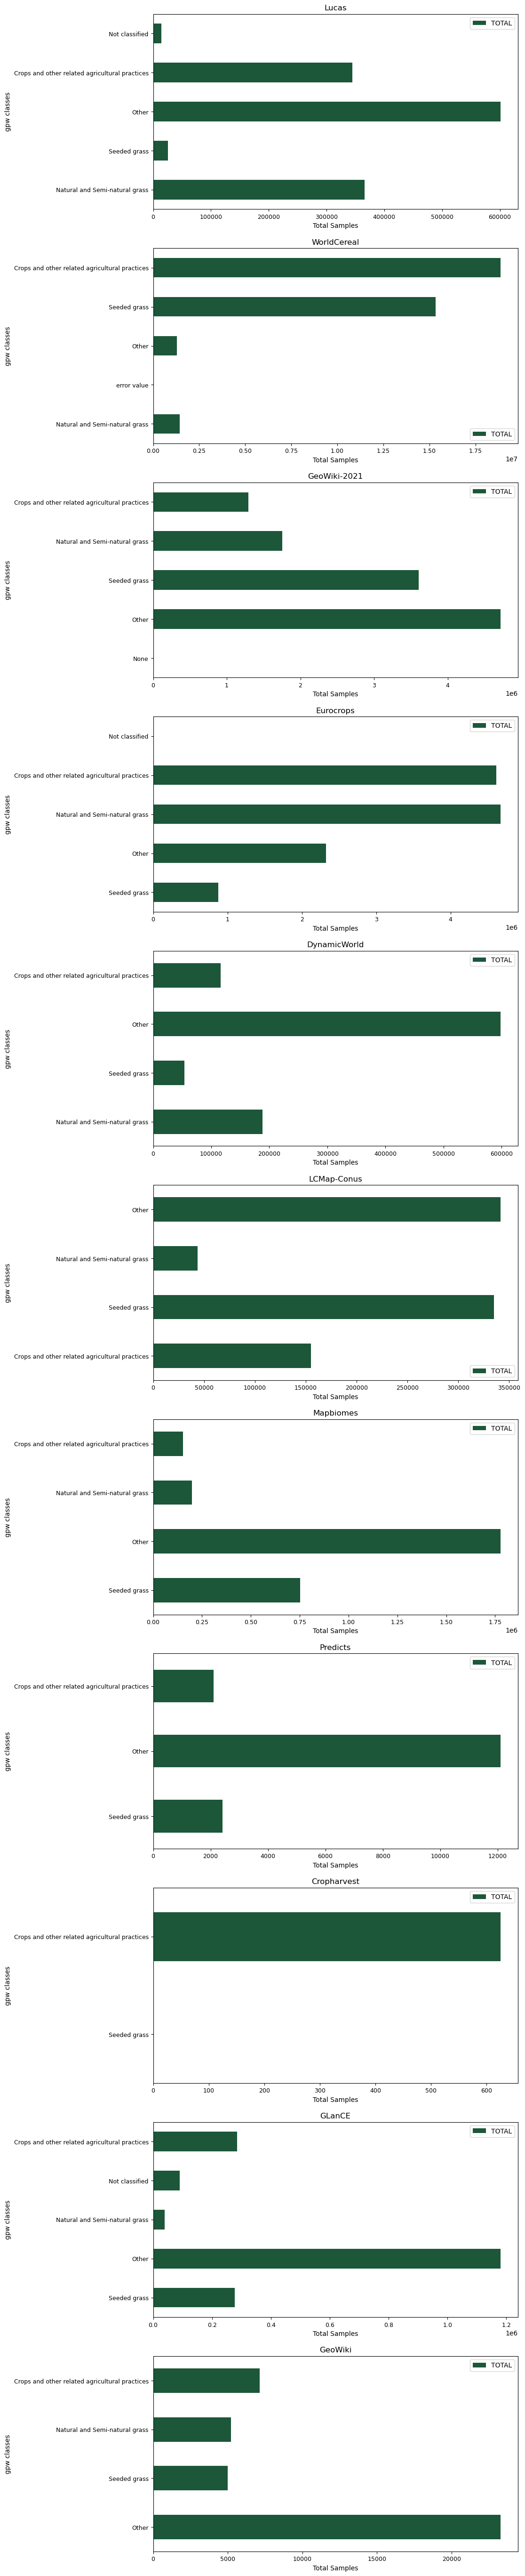

In [94]:
#Anaĺise de classes do Projeto GPW por base de dados
listdatasets = conn.sql(f"""SELECT DISTINCT dataset_name FROM '{db}';""").df()
listdatasets = listdatasets.dataset_name.to_list()

f, axs = plt.subplots(nrows=len(listdatasets), ncols=1, figsize=(10, 70))
axs = axs.flatten()
i = 0

for ds in listdatasets:
    plt.subplot(len(listdatasets),1,i+1);
    
    sql = f"""
        SELECT gpw_lulc_class, count(*) as TOTAL
        FROM '{db}'
        WHERE dataset_name == '{ds}'
        GROUP BY gpw_lulc_class;
    """
    ax = axs[i]
    df = conn.query(sql).df()
    _ = df.plot.barh(x='gpw_lulc_class', y='TOTAL',color='#1c5739',fontsize=9,
                     ylabel='gpw classes',xlabel='Total Samples',title=ds,ax=ax)
    i = i + 1

In [98]:
#Análise das amostras por anos
field = 'reference_year'
sql = f"""
    SELECT {field}, count(*) as TOTAL
    FROM '{db}'               
    GROUP BY {field}
    ORDER BY TOTAL;
    """ 
dfyear = conn.query(sql).df()
dfyear.head(10)

,reference_year,TOTAL
0,2022,598
1,1984,24996
2,1985,105141
3,1986,108636
4,1987,109608
5,1990,110115
6,1988,110119
7,1989,110145
8,1991,110146
9,1994,110214


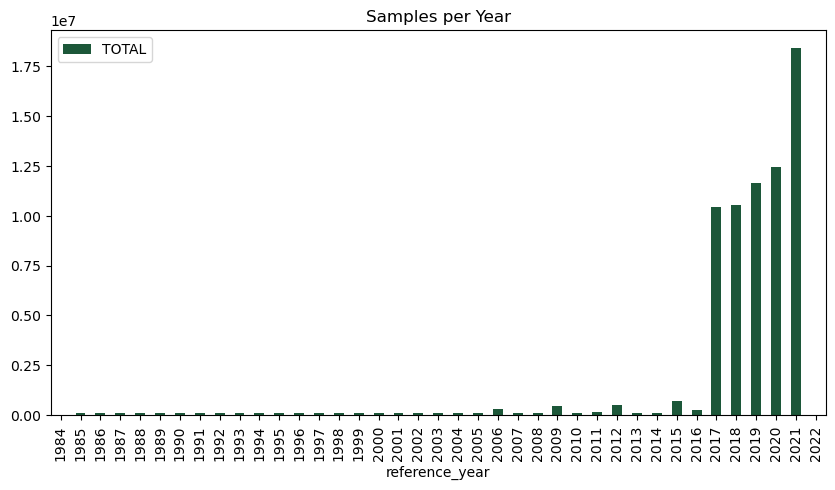

In [100]:
_=dfyear.sort_values(by=field).plot(title='Samples per Year',kind='bar',x=field,y='TOTAL',color='#1c5739',figsize=(10,5))

<AxesSubplot:title={'center':'Samples weight values distribuition'}, ylabel='Frequency'>

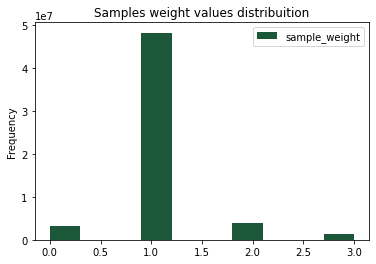

In [12]:
field = 'sample_weight'
conn.execute(
    f"""
    SELECT {field}
    FROM 'F:/trabalhos/Lapig/gpw/db/dbHarmo/parquet/*.parquet'
    WHERE {field} >= 0 and {field} < 4 
    """ 
).df().plot(title='Samples weight values distribuition',kind='hist',color='#1c5739')

In [102]:
#Amostras por continentes
continents = '/media/bernard/Data/LAPIG/Doutorado/Global_Pasture_Watch/datasets/14_Utils_data/Continents.shp'

dfcontinents = conn.execute(
    f"""
      SELECT reg.PLACENAME, count(pnt.geometry) as TOTAL_POINTS
        FROM (
            SELECT * 
            FROM ST_READ('{continents}')
        ) reg
        
        LEFT JOIN(
             SELECT * EXCLUDE geometry,ST_GeomFromWKB(geometry) as geometry FROM '{db}'
        ) pnt
        ON st_contains(reg.geom,pnt.geometry)
        GROUP BY reg.PLACENAME
        ORDER BY TOTAL_POINTS DESC;
           
    """
).df()
dfcontinents

,PLACENAME,TOTAL_POINTS
0,Europe,51064386
1,South America,5060220
2,North America,3970353
3,Africa,3304334
4,Asia,3093733
5,Australia,863188
6,Oceania East,60785
7,Antarctica,515
8,Oceania West,7


In [105]:
dfcontinents['Continent'] = dfcontinents['PLACENAME'].apply(lambda x: changeContinent(x))
dfcontinents

,PLACENAME,TOTAL_POINTS,Continent
0,Europe,51064386,Europe
1,South America,5060220,South America
2,North America,3970353,North America
3,Africa,3304334,Africa
4,Asia,3093733,Asia
5,Australia,863188,Australia/Oceania
6,Oceania East,60785,Australia/Oceania
7,Antarctica,515,Antarctica
8,Oceania West,7,Australia/Oceania


In [135]:
group = dfcontinents.groupby(by='Continent').sum('TOTAL_POINTS')
group.reset_index(inplace=True)
group.sort_values(by='TOTAL_POINTS',ascending=False)

,Continent,TOTAL_POINTS
4,Europe,51064386
6,South America,5060220
5,North America,3970353
0,Africa,3304334
2,Asia,3093733
3,Australia/Oceania,923980
1,Antarctica,515


<AxesSubplot:title={'center':'Samples per Continents'}, ylabel='Continent'>

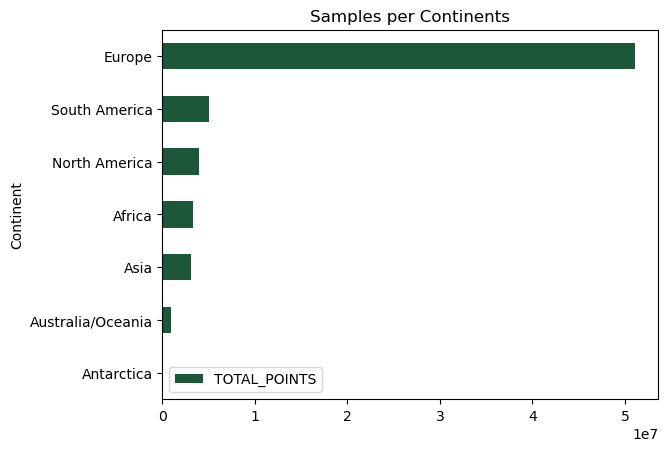

In [131]:
group.sort_values(by='TOTAL_POINTS').plot(
    title='Samples per Continents',kind='barh',
    x='Continent',y='TOTAL_POINTS',color='#1c5739')